# Baseline Model for Data Scientist Salaries Classification

## Setup Packages

### Install TensorFlow

In [1]:
!pip install tensorflow
!pip install tensorflow-privacy

In [2]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


### Install Other Libraries

In [3]:
import datetime
from datetime import datetime

from numpy.random import RandomState
import pandas as pd
from sklearn import preprocessing


## Setup Data

### Categorize Salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software Engineer,327000,"Seattle, WA",10.0,1.0,Distributed Systems (Back-End),155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62638,9/13/2018 8:23:32,Microsoft,62,Software Engineer,237000,"Redmond, WA",2.0,2.0,Full Stack,146900.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62639,9/13/2018 14:35:59,MSFT,63,Software Engineer,220000,"Seattle, WA",14.0,12.0,Full Stack,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software Engineer,280000,"San Francisco, CA",8.0,4.0,iOS,194688.0,...,0,0,0,0,0,0,0,0,NaN,NaN


<AxesSubplot:>

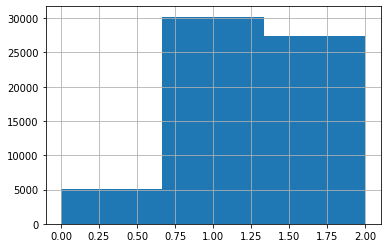

In [4]:
df = pd.read_csv('salaries.csv')
display(df)

salary_ranges = [0,80000,200000,np.inf]
df['salaryrange'] = pd.cut(df.totalyearlycompensation, salary_ranges, labels=[0,1,2], include_lowest=True)

df['salaryrange'].hist(bins=len(salary_ranges) - 1)

In [5]:
df.salaryrange.value_counts()

1    30203
2    27429
0     5010
Name: salaryrange, dtype: int64

### Make All Values Into Integers

In [6]:
# encode timestamp into integers, by year and month
def timestamp_to_int(timestamp):
    dt_obj = datetime.strptime(timestamp.split(' ')[0], '%m/%d/%Y')
    return (100 * dt_obj.year) + (dt_obj.month)

df['timestamp'] = df['timestamp'].apply(timestamp_to_int)

# turn company names to lowercase and encode as integers
df['company'] = df['company'].apply(lambda t: str(t).lower())
df['company'] = pd.Categorical(pd.factorize(df['company'])[0])

# encode level as integer
df['level'] = pd.Categorical(pd.factorize(df['level'])[0])

# encode title as integer
df['title'] = pd.Categorical(pd.factorize(df['title'])[0])

# encode tag as integer
df['tag'] = pd.Categorical(pd.factorize(df['tag'])[0])

# encode gender as integer
df['gender'] = pd.Categorical(pd.factorize(df['gender'])[0])

# encode Race as integer
df['Race'] = pd.Categorical(pd.factorize(df['Race'])[0])

# encode Education as integer
df['Education'] = pd.Categorical(pd.factorize(df['Education'])[0])


### Remove Rows

In [7]:
df = df[df['gender'] != -1]
df = df[df['Education'] != -1]
df = df[df['Race'] != -1]
df = df[(50000 < df['totalyearlycompensation']) & (df['totalyearlycompensation'] < 500000)]

### Drop Columns

In [8]:
# make model predict without knowledge of the totalyearlycompensation
df.drop('totalyearlycompensation', axis=1, inplace=True)

# location information is already encoded as an integer in 'cityid'
df.drop('location', axis=1, inplace=True)

# make model predict without knowledge of the base salary
df.drop('basesalary', axis=1, inplace=True)

# 'otherdetails' column requires NLP to interpret
df.drop('otherdetails', axis=1, inplace=True)

# 'rowNumber' column is unnecessary
df.drop('rowNumber', axis=1, inplace=True)

# education information is entirely encoded in the 'Education' column already
df.drop('Masters_Degree', axis=1, inplace=True)
df.drop('Bachelors_Degree', axis=1, inplace=True)
df.drop('Doctorate_Degree', axis=1, inplace=True)
df.drop('Highschool', axis=1, inplace=True)
df.drop('Some_College', axis=1, inplace=True)

# race information is entirely encoded in the 'Race' column already
df.drop('Race_Asian', axis=1, inplace=True)
df.drop('Race_White', axis=1, inplace=True)
df.drop('Race_Two_Or_More', axis=1, inplace=True)
df.drop('Race_Black', axis=1, inplace=True)
df.drop('Race_Hispanic', axis=1, inplace=True)

### Training/Testing Data

In [9]:
drop_indices = np.random.choice(df.index, len(df.index) % 1250, replace=False)
df.drop(drop_indices, inplace=True)

rng = RandomState()

df_train = df.sample(frac=0.8, random_state=rng)
df_test = df.loc[~df.index.isin(df_train.index)]

print('Whole Dataset')
display(df)
print('Training Dataset')
display(df_train)
print('Testing Dataset')
display(df_test)

Whole Dataset


,timestamp,company,level,title,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
15710,202001,9,11,1,5.0,5.0,1,145000.0,45000.0,0,7472,807.0,1,0,2
23532,202007,4,46,1,3.0,2.0,4,1000.0,11000.0,0,11521,819.0,3,2,1
23533,202007,9,12,1,6.0,6.0,0,125000.0,36000.0,0,7413,807.0,1,2,2
23534,202007,4,7,1,4.0,4.0,3,38000.0,20000.0,0,11527,819.0,1,1,2
23535,202007,807,62,1,5.0,0.0,0,22000.0,0.0,0,7419,807.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61824,202108,790,1410,1,0.0,0.0,1,0.0,15000.0,0,41795,0.0,1,2,0
61826,202108,449,133,1,2.0,2.0,0,0.0,0.0,0,7839,524.0,1,2,1
61828,202108,806,131,1,3.0,3.0,1,0.0,5000.0,0,35382,521.0,0,2,1
61830,202108,2,11,0,9.0,0.0,1464,46000.0,45000.0,1,11527,819.0,1,2,2


Training Dataset


,timestamp,company,level,title,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
56504,202107,6,44,1,5.0,0.0,1,160000.0,50000.0,0,11527,819.0,1,2,2
32288,202010,821,2,3,10.0,3.0,45,0.0,4000.0,1,40303,511.0,0,1,1
56833,202107,260,15,7,11.0,0.0,1574,50000.0,16000.0,1,7419,807.0,0,2,2
53991,202106,3,23,9,6.0,5.0,2346,45000.0,10000.0,0,7158,807.0,0,2,1
58289,202107,306,26,1,20.0,20.0,455,10000.0,40000.0,0,7422,807.0,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36150,202011,1,68,1,10.0,5.0,6,60000.0,12000.0,0,7422,807.0,1,2,2
49852,202104,894,2307,1,2.0,2.0,4,0.0,4000.0,0,6419,0.0,3,1,0
43981,202103,2,15,1,4.0,0.0,866,22000.0,13000.0,0,7433,855.0,4,2,1
42417,202102,3,23,1,6.0,0.0,7,38000.0,0.0,0,7158,807.0,0,0,2


Testing Dataset


,timestamp,company,level,title,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
23534,202007,4,7,1,4.0,4.0,3,38000.0,20000.0,0,11527,819.0,1,1,2
23544,202007,94,399,1,5.0,1.0,0,62000.0,10000.0,0,7419,807.0,2,3,2
23554,202007,4,8,1,1.0,0.0,15,14000.0,10000.0,1,11527,819.0,4,2,1
23556,202007,16,79,10,6.0,6.0,1279,4000.0,0.0,0,7422,807.0,1,1,1
23568,202007,100,137,1,15.0,2.0,0,50000.0,0.0,0,11527,819.0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61799,202108,16,302,1,1.0,0.0,7,33000.0,37000.0,0,7434,807.0,1,1,1
61822,202108,54,180,1,2.0,0.0,0,0.0,6000.0,0,40693,511.0,0,2,1
61824,202108,790,1410,1,0.0,0.0,1,0.0,15000.0,0,41795,0.0,1,2,0
61826,202108,449,133,1,2.0,2.0,0,0.0,0.0,0,7839,524.0,1,2,1


In [10]:
train_data = df_train.loc[:, df_train.columns != 'salaryrange'].to_numpy()
test_data = df_test.loc[:, df_test.columns != 'salaryrange'].to_numpy()

train_labels = df_train['salaryrange'].to_numpy()
test_labels = df_test['salaryrange'].to_numpy()

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(salary_ranges) - 1)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(salary_ranges) - 1)

## Make the Model

### Set Variables

In [11]:
epochs = 7
batch_size = 250

### Add Layers to Model

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(len(salary_ranges) - 1, activation='softmax')
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss='mean_absolute_error', metrics=['accuracy'])
model.build(train_data.shape)
model.summary()
model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  960       
                                                                 
 dense_1 (Dense)             multiple                  2080      
                                                                 
 dense_2 (Dense)             multiple                  99        
                                                                 
Total params: 3,139
Trainable params: 3,139
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 3750 samples
Epoch 1/7
15000/15000 [==============================] - 0s 9us/sample - loss: 0.4362 - acc: 0.3703 - val_loss: 0.3529 - val_acc: 0.5579
Epoch 2/7
  250/15000 [..............................] - ETA: 0s - loss: 0.3209 - acc: 0.6320

2022-05-09 21:56:35.904853: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


15000/15000 [==============================] - 0s 4us/sample - loss: 0.3320 - acc: 0.5471 - val_loss: 0.3115 - val_acc: 0.5579
Epoch 3/7
15000/15000 [==============================] - 0s 4us/sample - loss: 0.3122 - acc: 0.5471 - val_loss: 0.3014 - val_acc: 0.5579
Epoch 4/7
15000/15000 [==============================] - 0s 4us/sample - loss: 0.3025 - acc: 0.5471 - val_loss: 0.2872 - val_acc: 0.5579
Epoch 5/7
15000/15000 [==============================] - 0s 4us/sample - loss: 0.2649 - acc: 0.6383 - val_loss: 0.2287 - val_acc: 0.7632
Epoch 6/7
15000/15000 [==============================] - 0s 4us/sample - loss: 0.2062 - acc: 0.8057 - val_loss: 0.1786 - val_acc: 0.8307
Epoch 7/7
15000/15000 [==============================] - 0s 4us/sample - loss: 0.1688 - acc: 0.8267 - val_loss: 0.1518 - val_acc: 0.8464


In [14]:
model_loss, model_metric = model.evaluate(test_data, test_labels, batch_size=batch_size)
print(model_metric)

0.8464
